In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm
import sys
sys.path.insert(0, '../zdrojaky/kf')
from kf import KF
np.set_printoptions(precision=2)

# Stavové modely, Kalmanův filtr

**Obsah přednášky:**
- motivační příklad
- stavové modely
- Kalmanův filtr
- Rozšíření KF (EKF...)

## Motivační příklad

Uvažujme, že pozorujeme těleso vržené vzhůru a zajímá nás jeho rychlost $v_t$ a "přesná" výška $h_t$, které budeme nazývat **stavovými proměnnými** (nebo **stavem**). $t=1,2,\ldots$ jsou diskrétní časové okamžiky (např. sekundy). K dispozici máme nepřesná (tedy zašuměná) **měření** výšky získaná z GPS, tato měření označme $y_{h,t}$. Pro jednoduchost zanedbáme vliv odporových sil.

Ze středoškolské fyziky (a pro přítomnost šumu i statistiky) víme, že pro výšku $h_t$ a rychlost $v_t$ v čase $t$ platí

$$
\begin{aligned}
h_t &= h_{0} + v_0 \Delta_t - \frac{1}{2} g \Delta_t^2 + w_{h,t}, \\
v_t &= v_0 - g\Delta_t + w_{v,t},
\end{aligned}
$$

kde $g = 9.81ms^{-2}$ je gravitační zrychlení, $v_0$ je počáteční rychlost, $y_0$ je počáteční výška a $\Delta_t = t-t_0$ je doba od počátečního času $t_0$. Zpravidla $t_0 = 0$, čímž se z $\Delta_t$ stane jen $t$ a dostaneme vzorečky na něž jsme byli na střední škole zvyklí. Členy $w_{h,t}$ a $w_{v,t}$ představují šum na přítomných stavových veličinách.

Všimněme si, že **stav** je vlastně jakýsi **parametr** celého tohoto modelu, jenže narozdíl od klasického parametru se nám vyvíjí. Rychlost tělesa vrženého vzhůru bude klesat, zatímco výška bude stoupat.

V předmětu jsme si zvykli na sekvenční (online) modelování. Protože bychom chtěli podobně přistoupit k $h_t$ a $v_t$, jež se nám ale v čase vyvíjí, potřebovali bychom model trochu upravit, aby tento časový vývoj z času $t-1$ na čas $t$ zohlednil. Model si tedy přepíšeme:

$$
\begin{aligned}
h_t &= h_{t-1} + v_{t-1} \Delta_t - \frac{1}{2} g \Delta_t^2  + w_{h,t},\\
v_t &= v_{t-1} - g \Delta_t + w_{v,t}.
\end{aligned}
$$

Chceme-li modelovat více veličin současně, přepíšeme model do maticové podoby:

$$
\underbrace{
\begin{bmatrix}
h_t \\
v_t
\end{bmatrix}
}_{x_t}
=
\underbrace{
\begin{bmatrix}
1 & \Delta_t \\
0 & 1
\end{bmatrix}
}_{A_t}
\underbrace{
\begin{bmatrix}
h_{t-1} \\
v_{t-1}
\end{bmatrix}
}_{x_{t-1}}
+
\underbrace{
\begin{bmatrix}
- \frac{1}{2}\Delta_t^2 \\
- \Delta_t
\end{bmatrix}
}_{B_t}
\underbrace{
g
}_{u_t}
+
\underbrace{
\begin{bmatrix}
w_{h,t} \\
w_{v,t}
\end{bmatrix}
}_{w_t}.
$$

### Simulace vývoje stavu

Zkusme si takový pohyb nasimulovat. Připomeňme, že okamžitou rychlost $v_t$ ani skutečnou výšku $h_t$ neznáme a nedokážeme přímo měřit. Je to **vnitřní stav**, je danému objektu vlastní, ale nemáme o něm přesnou informaci.

> Je to trochu podobné jako s náladou. Každý z nás má nějaký vnitřní stav, který se nevyvíjí podle nějakého deterministického náladového modelu, ale značnou roli v jejím vývoji mají náhodné jevy (tedy "šum").

Pusťme si tedy simulaci na `ndat` kroků (tj. sekund). Počáteční výšku a rychlost $h_0$ a $v_0$ dáme do proměnných `h0, v0`. Ty tvoří počáteční stav $x_0$ v proměnné `x[:,0]`. Ten vložíme do maticového modelu výše a dostaneme stav $x_1$. A tak dál dokola. V proměnné `x` ukládáme do `ndat` sloupců dvě položky - výšku a rychlost. Samozřejmě to je pro simulaci, normálně bychom pracovali jen s danou dvojicí. Rychlost vzhůru stoupajícího objektu bude klesat do nuly a pak opět růst, ale s opačným směrem, tj. se znaménkem mínus.

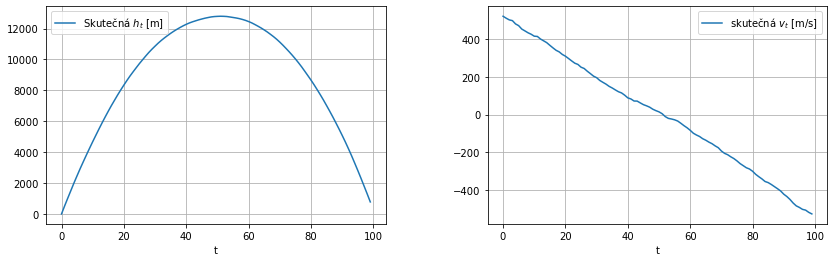

In [73]:
ndat = 100                               ### počet dat
h0 = 0                                   ### počáteční výška [m]
v0 = 520                                 ### počáteční rychlost [m/s]
g = 9.81                                 ### grav. zrychlení [m/s^2]
dt = 1                                   # čas. krok v sekundách
A = np.array([[1, dt], [0, 1]])          # matice A
B = np.array([-.5*dt, -dt])              # matice B
u = g                                    # pro forma, g=u
var_wht = 10                             ### variance šumu na výšce w_ht
var_wvt = 10                             ### variance šumu na rychlosti w_vt

x = np.zeros((2, ndat))
x[:,0] = [h0, v0]

for t in range(1, ndat):
    x[:,t] = A.dot(x[:,t-1]) + B.dot(u)
    x[:,t] += mvn.rvs(cov=np.diag([var_wht, var_wvt]))
    
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(x[0], label=r'Skutečná $h_t$ [m]')
plt.legend()
plt.xlabel('t')
plt.subplot(122)
plt.plot(x[1], label=r'skutečná $v_t$ [m/s]')
plt.legend()
plt.xlabel('t')
plt.show()

## Pozorovaná veličina

Stav $x_t=[h_t, v_t]^\intercal$ sice nemůžeme přímo pozorovat, ale můžeme nějak více či méně nepřesně měřit různé související veličiny, např. "přístrojovou výšku" získanou GPS přijímačem ve vrženém objektu nebo "radarovou výšku" měřenou radarem na zemi. Označíme naši pozorovanou (měřenou) výšku $y_{h,t}$. Jde zřejmě o skutečnou výšku (stavová veličina $h_t$) zatíženou nějakou větší či menší nepřesností měření $\varepsilon_t$:

$$
y_{h,t} = h_t + \varepsilon_t.
$$

Jelikož máme ale vektor stavů, můžeme použít ekvivalentní zápis

$$
y_{h,t}
=
\underbrace{
\begin{bmatrix}
1 & 0 \\
\end{bmatrix}
}_{H_t}
x_t
+ \varepsilon_t.
$$

> Vrátíme-li se k myšlence nálady jako vnitřního stavu, pak lze říci, že ta je na nás pozorovatelná, ale pozorování nejsou přesná. Jsou totiž zatížena "šumem", který více či méně skrývá skutečný stav. Oproti náladě bychom ale u našich modelů stáli o to, aby šum nevnášel systematickou chybu.

### Výsledný stavový model:
$$
\begin{aligned}
x_t &=
\begin{bmatrix}
1 & \Delta_t \\
0 & 1
\end{bmatrix}
x_{t-1}
+
\begin{bmatrix}
- \frac{1}{2}\Delta_t^2 \\
- \Delta_t
\end{bmatrix}
g
+
\begin{bmatrix}
w_{h,t} \\
w_{v,t}
\end{bmatrix}
\\
y_{h,t}
&=
\begin{bmatrix}
1 & 0
\end{bmatrix}
x_t
+ \varepsilon_t.
\end{aligned}
$$

---

>**OBECNĚ**
>$$
\begin{aligned}
x_t &= A_t x_{t-1} + B_t u_t + w_t, \\
y_t &= H_t x_t + \varepsilon_t,
\end{aligned}
$$
>
> kde $x_t$ je **stav**, $u_t$ je **řídící veličina**, $w_t$ a $\varepsilon_t$ jsou **šum stavu** a **šum měření** a $A_t, B_t$ a $H_t$ jsou matice patřičných rozměrů.

---

### Simulace včetně pozorování

Celá simulace by pak vypadala následovně:

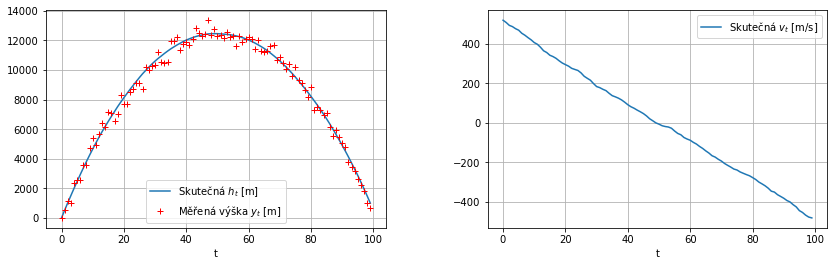

In [77]:
ndat = 100                               ### počet dat
h0 = 0                                   ### počáteční výška [m]
v0 = 520                                 ### počáteční rychlost [m/s]
g = 9.81                                 ### grav. zrychlení [m/s^2]
dt = 1                                   # čas. krok v sekundách
A = np.array([[1, dt], [0, 1]])          # matice A
B = np.array([-.5*dt, -dt])              # matice B
u = g                                    # pro forma, g=u
var_wht = 10                             ### variance šumu na výšce w_ht
var_wvt = 10                             ### variance šumu na rychlosti w_vt
var_y = 400**2                           ### variance šumu měření epsilon_t

x = np.zeros((2, ndat))
x[:,0] = [h0, v0]
y = np.zeros(ndat)

for t in range(1, ndat):
    x[:,t] = A.dot(x[:,t-1]) + B.dot(u)
    x[:,t] += mvn.rvs(cov=np.diag([var_wht, var_wvt]))
    y[t] = x[0,t] + norm.rvs(scale=np.sqrt(var_y))
    
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(x[0], label=r'Skutečná $h_t$ [m]')
plt.plot(y, '+r', label=r'Měřená výška $y_t$ [m]')
plt.legend()
plt.xlabel('t')
plt.subplot(122)
plt.plot(x[1], label=r'Skutečná $v_t$ [m/s]')
plt.legend()
plt.xlabel('t')
plt.show()

# Stavový model

Stavový model nějakého systému nebo procesu je charakterizován třemi veličinami:
- **stavem**, označeným zpravidla $x_t$, který nemůžeme pozorovat, ale můžeme jej odhadovat,
- **vstupem**, též nazývaným **řídící veličinou** $u_t$, kterou známe,
- **výstupem**, výše označeným $y_t$, což pozorovatelná veličina determinovaná stavovou a řídící veličinou $x_t$ a $u_t$.

Stavový model může být v čase buď **diskrétní**, tj. popsaný v časových okamžicích $t=1,2,\ldots$, nebo **spojitý**, pak je popsaný derivacemi. My se budeme striktně držet diskrétního stavu.

Obecně zapisujeme stavový model jako známé (nicméně kvůli šumu stochastické) funkce stavů a vstupů, přičemž tyto funkce mohou a nemusí být v čase konstantní,

$$
\begin{aligned}
x_t &= f_t(x_{t-1}, u_t), \\
y_t &= g_t(x_t).
\end{aligned}
$$

V teorii řízení je často vstupní (řídící) veličina i ve funkci $g_t$, my pro jednoduchost budeme uvažovat uvedený případ. Je-li systém lineární, potom - jak už bylo uvedeno výše - jej můžeme zapsat

>$$
\begin{aligned}
x_t &= A_t x_{t-1} + B_t u_t + w_t, \\
y_t &= H_t x_t + \varepsilon_t,
\end{aligned}
$$

kde $x_t$ je **stav**, $u_t$ je **řídící veličina**, $w_t$ a $v_t$ jsou **šum stavu** a **šum měření** a $A_t, B_t$ a $H_t$ jsou matice patřičných rozměrů. Pokud je systém časově invariantní, jsou matice konstantní, $A_t=A, B_t=B, H_t=H$.

## Markovská vlastnost, skrytý markovský model (Hidden Markov Models, HMM)

V souvislosti se stavovými modely se často mluví o markovské vlastnosti. Markovský proces, též markovský model 1. řádu, je model, v němž aktuální stav závisí pouze na stavu předchozím. Je tedy popsán pravděpodobnostmi

$$
\begin{alignat}{2}
&p(x_t|x_{t-1}) &&\qquad\text{(pravděpodobnost přechodu)}, \\
&p(x_0) &&\qquad\text{(počáteční stav)}.
\end{alignat}
$$

Pokud bychom pracovali s modelem vyššího řádu, např. $n$-tého, byla by pravděpodobnost přechodu $p(x_t|x_{t-1},...,x_{t-n})$. To ovšem vede k náročnějším výpočtům.

Pokud není markovský proces přímo pozorovatelný, ale lze na něj nahlížet prostřednictvím jiné pozorovatelné veličiny $y_t$, mluvíme o **skrytém markovském procesu**. My budeme navíc předpokládat, že celý proces je *spojitý*.

![HMM](img/hmm.png)

**Úkoly:**
- najdete ve stavovém modelu markovskou vlastnost?
- rozpoznáte ve stavovém modelu HMM?

# Kalmanův filtr

- autorství je připisováno americkém matematikovi a inženýrovi maďarského původu Rudolfu E. Kálmánovi.
- podobné algoritmy ale vznikaly i o něco dříve (Swerling, Thiele), souběžně (Bucy).
- obecnější filtr v pojetí stochastické analýzy navrhl dříve sovětský matematik Ruslan Stratonovič. KF je jeho speciálním případem.
- první aplikace - S.F. Schmidt - program Apollo (navigace).

![Kalman](img/Rudolf_Kalman.jpg)

### Aplikace: 
- Apollo (navigace)
- zbraňové systémy (ponorky, rakety, střely Tomahawk)
- navigační systémy obecně
- autopiloty
- computer vision (https://www.youtube.com/watch?v=sG-h5ONsj9s)
- target tracking (https://www.youtube.com/watch?v=p9FXMf_HRw0)
- modely v ekonometrii
- inerciální navigační systémy (https://www.youtube.com/watch?v=Zc9jg1y08ew)
- bezsenzorové řízení AC elektromotorů
- předpovědi počasí
- a spousty dalších. V mobilech, autech...

## Odvození Kalmanova filtru

Vraťme se ke stavovému modelu (pro jednoduchost časově invariantnímu) zadanému systémem rovnic

$$
\begin{aligned}
x_t &= A x_{t-1} + B u_t + w_t, \\
y_t &= H x_t + \varepsilon_t,
\end{aligned}
$$

kde obě šumové proměnné budiž nezávislé normální a centrované v nule

$$
\begin{aligned}
w_t &\sim \mathcal{N}(0, Q),\\
\varepsilon_t &\sim \mathcal{N}(0, R).
\end{aligned}
$$

*Normalita není pro samotný filtr nutná*, ale my ji budeme potřebovat. Navíc nese nějaké výhody související s optimalitou, ale to ponechme stranou. Z normality nicméně vidíme, že

$$
\begin{alignat}{2}
x_t &\sim \mathcal{N}(Ax_{t-1} + Bu_t, Q) &&\qquad\text{s hustotou}\quad p(x_t|x_{t-1}, u_t) \\
y_t &\sim \mathcal{N}(Hx_{t}, R) &&\qquad\text{s hustotou}\quad f(y_t|x_t).
\end{alignat}
$$

(Uvědomte si proč! Je to stejné jako u lineární regrese.)

Jelikož hodláme k filtraci (tj. sekvenčnímu odhadu) stavu $x_t$ přistoupit bayesovsky, potřebujeme ještě apriorní distribuci pro $x_t$. Model $y_t$ je normální, konjugované apriorno bude tedy rovněž normální se střední hodnotou označenou $x_{t-1}^{+}$ a kovarianční maticí $x_{t-1}^{+}$,

$$
\pi(x_t|y_{0:t-1}, u_{0:t-1}) = \mathcal{N}(x_{t-1}^{+}, P_{t-1}^{+}).
$$

Kalmanův filtr běží ve dvou krocích - **predikce stavu** a **update stavu** (též korekce). Predikce využije první ze stavových rovnic - kdyby stavy $x_t$ a měření $y_t$ nebyly zašuměné, update bychom vlastně ani nepotřebovali, neboť by byla stoprocentní kauzalita mezi odhadovaným $x_t$ a měřeným $y_t$. Stačilo by jen sáhnout po druhé rovnici a inverzí se dopátrat k $x_t$ (soustava 2 rovnic o dvou proměnných, učivo základní školy). Nicméně protože je na měřeních přítomný šum, použijeme predikovaný stav jako apriorní informaci do Bayesovy věty, kde ji pomocí měření zkorigujeme.

### Predikce

Smyslem predikce je použít model pro vývoj stavu a předpovědět na základě odhadu stavu v předchozím okamžiku, jaký bude stav nyní. Tj. řešíme časový vývoj stavu $x_{t-1} \to x_t$. Použijeme tedy odhad reprezentovaný posledním aposteriornem, nyní apriornem pro další časový krok a ten "proženeme" modelem vývoje:

$$
\pi(x_{t}|y_{0:t-1}, u_{0:t})
= \int p(x_{t}|x_{t-1}, u_{t})\, \pi(x_{t-1}|y_{0:t-1}, u_{0:t-1})\, \mathrm{d}x_{t-1}.
$$

Jelikož násobíme dvě normální distribuce a marginalizujeme, dostaneme opět normální distribuci
$\mathcal{N}(x_{t}^{-}, P_{t}^{-})$ s hyperparametry

$$
\begin{aligned}
    x_{t}^{-} &= A x_{t-1}^{+} + B u_{t}, \\
    P_{t}^{-} &= A P_{t-1}^{+} A^{\intercal} + Q.
\end{aligned}
$$

Vidíme, že násobení dvou normálních distribucí a následná marginalizace vlastně jen vyčíslí rovnici pro stav. Odhad stavu $x_t^{-}$ je prosté dosazení do příslušné rovnice v maticích na začátku notebooku. Kovariance odhadu $P_t^{-}$ vyjadřuje míru neurčitosti (nejistoty) tohoto odhadu. Protože jsme jen predikovali, ale nepoužili žádné pozorování na korekci této predikce, musí být neurčitost větší. 

> Vzpomeňte na BI-PST a lineární transformaci náhodné veličiny $X$ prostřednictvím $A,B\in\mathbb{R}$:
> $$\mathbb{E}[AX + B] = A\mathbb{E}[X] + B, \qquad \mathrm{var}\, (AX+B) = A^2\, \mathrm{var}\, (X) = A\,\mathrm{var}\, (X)\,A.$$
> Přesně to jsme použili výše :)

### Update

Update neboli korekce "opraví" predikovaný odhad novými pozorováními $y_t$. K tomu slouží Bayesova věta,

$$
\pi(x_{t}|y_{0:t}, u_{0:t}) 
\propto
f(y_{t}|x_{t})
\pi(x_{t}|y_{0:t-1}, u_{0:t}) 
$$

Už v minulosti (v přednášce o regresi) se nám osvědčilo přepsat si model do tvaru distribuce z exponenciální třídy a k tomu vhodně napsat i apriorno. Potom je bayesovský update jen součet hyperparametru a suficientní statistiky. Model bude vypadat následovně:

$$
\begin{aligned}
    f(y_{t}|x_{t})
    &\propto \exp
        \left\{ 
            -\frac{1}{2} 
            (y_{t} - H x_{t})^{\intercal}
            R^{-1}
            (y_{t} - H x_{t})
        \right\} \\
    &= \exp
        \Bigg\{ 
            \operatorname{Tr}
            \bigg(
            \underbrace{
                -\frac{1}{2}
                \begin{bmatrix}
                    -1 \\ x_{t}
                \end{bmatrix}
                \begin{bmatrix}
                    -1 \\ x_{t}
                \end{bmatrix}^{\intercal}
            }_{\eta}
            \underbrace{
                \begin{bmatrix}
                    y_{t}^{\intercal} \\ H^{\intercal}
                \end{bmatrix}
                R^{-1}
                \begin{bmatrix}
                    y_{t}^{\intercal} \\ H^{\intercal}
                \end{bmatrix}^{\intercal}
            }_{T(y_{t})}
            \bigg)
        \Bigg\}.
\end{aligned}
$$

Konjugovaný tvar apriorna má podobu

$$
\begin{aligned}
    \pi(x_{t}|y_{0:t-1}, u_{0:t}) 
    &\propto \exp
        \left\{ 
            -\frac{1}{2} 
            (x_{t} - x_{t}^{-})^{\intercal}
            (P_{t}^{-})^{-1}
            (x_{t} - x_{t}^{-})
        \right\} \notag \\
    &= \exp
        \Bigg\{
            \operatorname{Tr}
            \bigg(
            \underbrace{
                -\frac{1}{2}
                \begin{bmatrix}
                    -1 \\ x_{t}
                \end{bmatrix}
                \begin{bmatrix}
                    -1 \\ x_{t}
                \end{bmatrix}^{\intercal}
            }_{\eta}
            \underbrace{
                \begin{bmatrix}
                    (x_{t}^{-})^{\intercal} \\ I
                \end{bmatrix}
                (P_{t}^{-})^{-1}
                \begin{bmatrix}
                    (x_{t}^{-})^{\intercal} \\ I
                \end{bmatrix}^{\intercal}
            }_{\xi_{t}}
            \bigg)
        \Bigg\},
        \notag
\end{aligned}
$$
kde $I$ je jednotková matice odpovídajícího rozměru.

Bayesovský update je součet hyperparametru a suficientní statistiky,

$$
\begin{aligned}
    \xi_{t} 
    &= \xi_{t-1} +  T(y_{t})  \notag \\
    &=
    \begin{bmatrix}
        (x_{t}^{-})^{\intercal} (P_{t}^{-})^{-1} x_{t}^{-} + y_{t}^{\intercal} R^{-1} y_{t}, 
            & (x_{t}^{-})^{\intercal} (P_{t}^{-})^{-1} + y_{t}^{\intercal} R^{-1} H \\
        (P_{t}^{-})^{-1} (x_{t}^{-})^{\intercal} + H^{\intercal} R^{-1} y_{t}, 
        & (P_{t}^{-})^{-1} + H^{\intercal} R^{-1} H.
    \end{bmatrix}
\end{aligned}
$$

Aposteriorní parametry normálního rozdělení odvodíme snadno,

$$
\begin{aligned}
    P_{t}^{+} &= (\xi_{t;[2,2]})^{-1} \\
              &= \left[ (P_{t}^{-})^{-1} + H^{\intercal} R^{-1} H \right]^{-1} \\
              &= (I - K_{t} H) P_{t}^{-} \\
    x_{t}^{+} &= (\xi_{t;[2,2]})^{-1} \xi_{t;[2,1]} \\
              &= P_{t}^{+} \left[ (P_{t}^{-})^{-1} (x_{t}^{-})^{\intercal} + H^{\intercal} R^{-1} y_{t}\right]  \\
              &= x_{t}^{-} + P_{t}^{+} H^{\intercal} R^{-1}(y_{t} - Hx_{t}^{-})
\end{aligned}
$$

kde

$$
   K_{t} = P_{t}^{-} H^{\intercal}(R + H P_{t}^{-}H^{\intercal})
$$

je Kalmanovo zesílení. Konkrétně uvedená podoba je *optimální Kalmanovo zesílení*, neboť minimalizuje střední kvadratickou chybu. Obecně čím větší zesílení, tím větší důraz nová měření. Filtr je pak citlivější, ale hůře filtruje šum.

Není bez zajímavosti, že poslední výrazy pro $x_t^{+}, P_t^{+}$ a $K_t$ nejsou bayesovskou specialitou, ale vzniknou i nebayesovským odvozením. Ostatně bayesovský pohled na Kalmanův filtr vznikl výrazně později, než filtr samotný.

## V pythonu...

Vrátíme se k našemu příkladu s volným pádem. Pustíme filtr a uvidíme.

In [116]:
Q = np.diag([var_wht, var_wvt])           # Toto už jsme v simulaci také udělali
R = var_y
H = np.array([1, 0])

filtr = KF(A=A, B=B, H=H, R=R, Q=Q)       # Instance Kalmanova filtru
filtr.P = np.eye(2) * 10.**2
filtr.x = np.array([0., 400.])

for t, yt in enumerate(y):
    filtr.predict(u)
    if t < 30 or t > 80:
        filtr.update(yt)
    filtr.log()
    
log_x = np.array(filtr.log_x).T
log_P = np.array(filtr.log_P)

### Měření
Nejdříve se podívejme, co vlastně máme k dispozici. Jen zašuměná měření výšky z GPS.

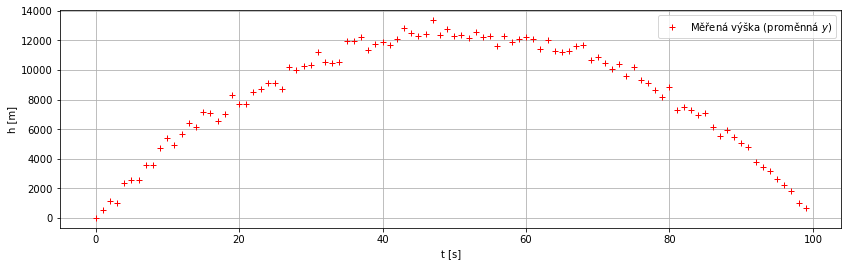

In [117]:
plt.figure(figsize=(14,4))
plt.plot(y, '+r', label=r'Měřená výška (proměnná $y$)')
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('h [m]')
plt.show()

Doplníme do toho odhad výšky z Kalmanova filtru.

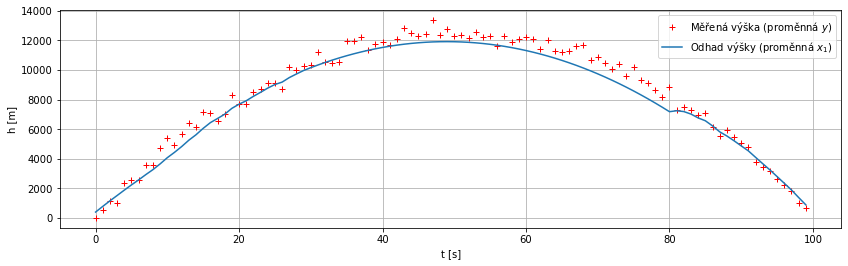

In [118]:
plt.figure(figsize=(14,4))
plt.plot(y, '+r', label=r'Měřená výška (proměnná $y$)')
plt.plot(log_x[0], label=r'Odhad výšky (proměnná $x_1$)')
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('h [m]')
plt.show()

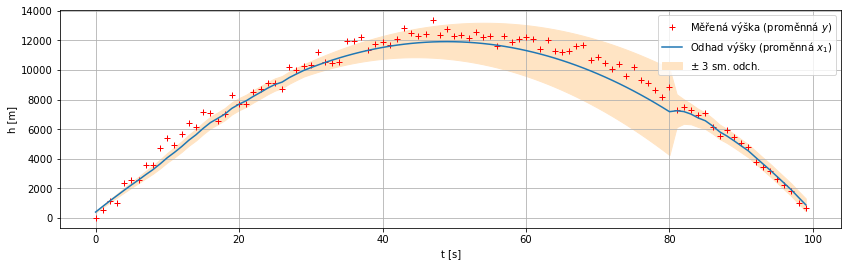

In [119]:
plt.figure(figsize=(14,4))
plt.fill_between(np.arange(ndat),
                 log_x[0] + 3*np.sqrt(log_P[:,0]),
                 log_x[0] - 3*np.sqrt(log_P[:,0]), 
                 color='bisque', label=r'$\pm$ 3 sm. odch.')
plt.plot(y, '+r', label=r'Měřená výška (proměnná $y$)')
plt.plot(log_x[0], label=r'Odhad výšky (proměnná $x_1$)')
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('h [m]')
plt.show()

A do třetice podobný obrázek, vložíme i skutečnou výšku. Pravděpodobně uvidíme, že filtr se nejdříve musel chvilku učit, ale pak už by měl běžet dobře, pokud není příliš vysoká úroveň šumu ([SNR, signal-to-noise ratio](https://en.wikipedia.org/wiki/Signal-to-noise_ratio))

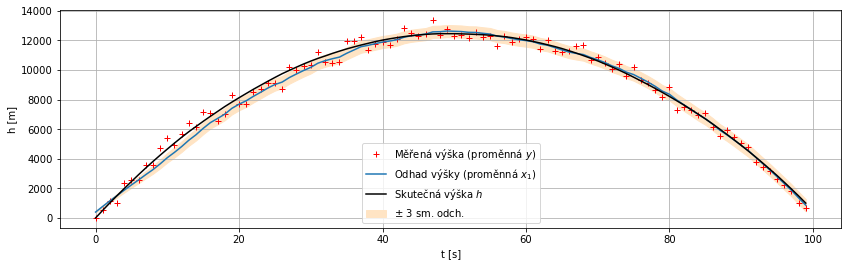

In [114]:
plt.figure(figsize=(14,4))
plt.fill_between(np.arange(ndat),
                 log_x[0] + 3*np.sqrt(log_P[:,0]),
                 log_x[0] - 3*np.sqrt(log_P[:,0]),
                 color='bisque', label=r'$\pm$ 3 sm. odch.')
plt.plot(y, '+r', label=r'Měřená výška (proměnná $y$)')
plt.plot(log_x[0], label=r'Odhad výšky (proměnná $x_1$)')
plt.plot(x[0], 'k', label=r'Skutečná výška $h$')
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('h [m]')
plt.show()

A zajímá nás ještě odhad rychlosti $v$. Zde se bude filtr pravděpodobně také chvilku učit, ale pak by se měl chytit. **Připomeňme, že odhad této veličiny je jen na základě měření výšky, rychlost nám nic neměří, a to ani přibližně!**

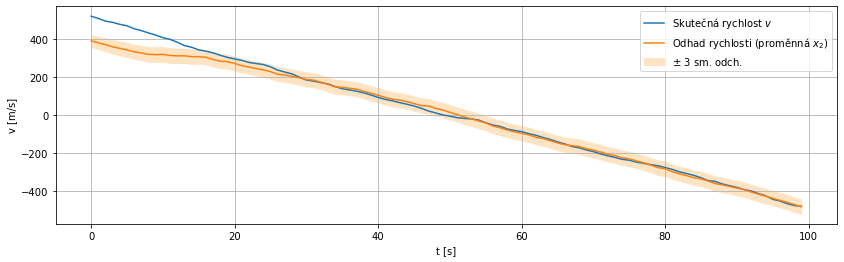

In [115]:
plt.figure(figsize=(14,4))
plt.fill_between(np.arange(ndat),
                 log_x[1] + 3*np.sqrt(log_P[:,1]),
                 log_x[1] - 3*np.sqrt(log_P[:,1]), 
                 color='bisque', label=r'$\pm$ 3 sm. odch.')
plt.plot(x[1], label=r'Skutečná rychlost $v$')
plt.plot(log_x[1], label=r'Odhad rychlosti (proměnná $x_2$)')
plt.xlabel('t [s]')
plt.ylabel('v [m/s]')
plt.legend()
plt.show()

# Nelineární stavové modely

Nelineární stavové modely jsou opět ve tvaru

$$
\begin{aligned}
x_t &= f_t(x_{t-1}, u_t), \\
y_t &= g_t(x_t),
\end{aligned}
$$

ovšem jedna nebo obě funkce již nejsou lineární. Zde je více možností řešení:

1. Při slabé nelinearitě lze funkce lokálně linearizovat derivacemi prvního řádu, popřípadě druhého řádu. Tím dostaneme [rozšířený Kalmanův filtr (extended Kalman filter, EKF)](https://en.wikipedia.org/wiki/Extended_Kalman_filter). Ten již není optimální a může potenciálně i divergovat, nicméně za "rozumných" podmínek funguje dobře a je standardem v GPS navigaci.
2. Při větších nelinearitách lze využít tzv. [unscented Kalmanův filtr (UKF)](https://en.wikipedia.org/wiki/Kalman_filter#Unscented_Kalman_filter).
3. V každém případě lze přikročit k filtraci hrubou silou pomocí Monte Carlo vzorkování stavů ze souvisejícího stavového prostoru. To velmi zjednodušeně znamená vygenerovat hromadu náhodných vektorů $x_t$, vložit je do stavového modelu a zjistit, které jsou nejpravděpodobnější pro daná měření $y_t$. Těm se přiřadí vysoké váhy a hledá se v jejich okolí. Příkladem takového filtru je [filtr částicový (particle filter)](https://en.wikipedia.org/wiki/Particle_filter). Ten bude obsahem některých z příštích přednášek.